# Dataset 

In [1]:
import os 
import pandas as pd 

def create_set(dataset_dir):
    data = [] 

    for folder in os.scandir(dataset_dir):
        for file in os.scandir(folder.path):
            data.append({
                "path": file.path, 
                "class": folder.name
            })

    return pd.DataFrame(data, index=None)

In [2]:
train = create_set("../data/fixed_ayd/train")
test = create_set("../data/fixed_ayd/test") 
# val = create_set("../data/fixed_ayd/val")

# Data Generators 

In [3]:
import tensorflow as tf 

IMG_SIZE = (224, 224) 
TRAIN_DIR = "../data/fixed_ayd/train/"
VAL_DIR = "../data/fixed_ayd/val/"
TEST_DIR = "../data/fixed_ayd/test/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True) 

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True) 

val_data = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True) 

Found 17132 files belonging to 17 classes.
Found 5711 files belonging to 17 classes.
Found 5710 files belonging to 17 classes.


# Models:

## 1.Very Base Model With EfficientNet BO 

In [5]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

In [6]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [7]:
checkpoint_path = './checkpoints/model_1/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 

In [8]:
model_1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(), 
                  tf.keras.metrics.Precision()]) 

In [9]:
model_1_history = model_1.fit(train_data, 
                            epochs=10, 
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback]) 

Epoch 1/10
536/536 [==============================] - 941s 2s/step - loss: 1.4402 - recall: 0.3037 - precision: 0.7976 - val_loss: 1.1914 - val_recall: 0.4347 - val_precision: 0.8058
Epoch 2/10
536/536 [==============================] - 934s 2s/step - loss: 1.1111 - recall: 0.4675 - precision: 0.8027 - val_loss: 1.0987 - val_recall: 0.4986 - val_precision: 0.8033
Epoch 3/10
536/536 [==============================] - 969s 2s/step - loss: 1.0185 - recall: 0.5168 - precision: 0.8120 - val_loss: 1.0658 - val_recall: 0.5208 - val_precision: 0.8027
Epoch 4/10
536/536 [==============================] - 972s 2s/step - loss: 0.9633 - recall: 0.5445 - precision: 0.8176 - val_loss: 1.0370 - val_recall: 0.5378 - val_precision: 0.7966
Epoch 5/10
536/536 [==============================] - 955s 2s/step - loss: 0.9212 - recall: 0.5657 - precision: 0.8225 - val_loss: 1.0164 - val_recall: 0.5569 - val_precision: 0.7996
Epoch 6/10
536/536 [==============================] - 932s 2s/step - loss: 0.8885 - r

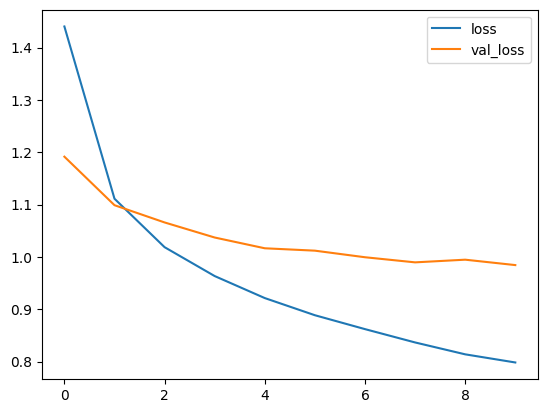

In [13]:
import matplotlib.pyplot as plt 

pd.DataFrame(model_1_history.history)[["loss", "val_loss"]].plot() 
plt.show()

In [15]:
hist = pd.DataFrame(model_1_history.history)


def calculate_f1(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist.head() 

,loss,recall,precision,val_loss,val_recall,val_precision,f1_score,val_f1_score
0,1.440235,0.303701,0.797639,1.191440,0.434676,0.805844,0.439907,0.564733
1,1.111084,0.467488,0.802746,1.098726,0.498599,0.803330,0.590874,0.615302
2,1.018488,0.516811,0.811996,1.065768,0.520841,0.802699,0.631617,0.631758
3,0.963296,0.544537,0.817616,1.036968,0.537828,0.796628,0.653703,0.642133
4,0.921243,0.565725,0.822471,1.016397,0.556918,0.799598,0.670356,0.656550


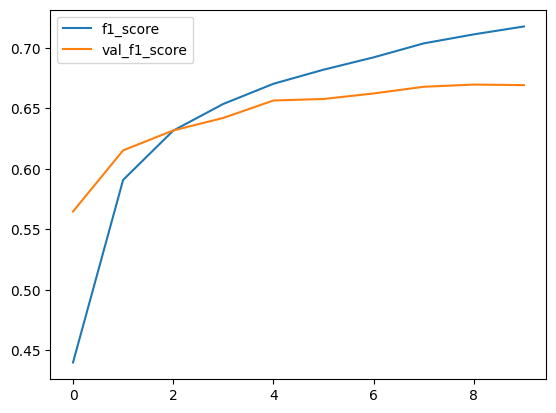

In [16]:
hist[["f1_score", "val_f1_score"]].plot() 
plt.show()

### Model 1 fine tune 

In [17]:
base_model.trainable = True  

for layer in base_model.layers[:-5]:
    layer.trainable = False 

model_1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=[
                  tf.keras.metrics.Recall(), 
                  tf.keras.metrics.Precision()]) 

In [18]:
model_1_history_fine = model_1.fit(train_data, 
                            epochs=30, 
                            initial_epoch=10,
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback]) 

Epoch 11/30
536/536 [==============================] - 991s 2s/step - loss: 0.7746 - recall_1: 0.6468 - precision_1: 0.8330 - val_loss: 0.9630 - val_recall_1: 0.6156 - val_precision_1: 0.7775
Epoch 12/30
536/536 [==============================] - 977s 2s/step - loss: 0.6983 - recall_1: 0.6821 - precision_1: 0.8521 - val_loss: 0.9387 - val_recall_1: 0.6187 - val_precision_1: 0.7816
Epoch 13/30
536/536 [==============================] - 979s 2s/step - loss: 0.6428 - recall_1: 0.7083 - precision_1: 0.8639 - val_loss: 0.9278 - val_recall_1: 0.6306 - val_precision_1: 0.7880
Epoch 14/30
536/536 [==============================] - 998s 2s/step - loss: 0.5915 - recall_1: 0.7310 - precision_1: 0.8791 - val_loss: 0.9257 - val_recall_1: 0.6357 - val_precision_1: 0.7728
Epoch 15/30
536/536 [==============================] - 985s 2s/step - loss: 0.5520 - recall_1: 0.7490 - precision_1: 0.8876 - val_loss: 0.9249 - val_recall_1: 0.6370 - val_precision_1: 0.7770
Epoch 16/30
536/536 [===================

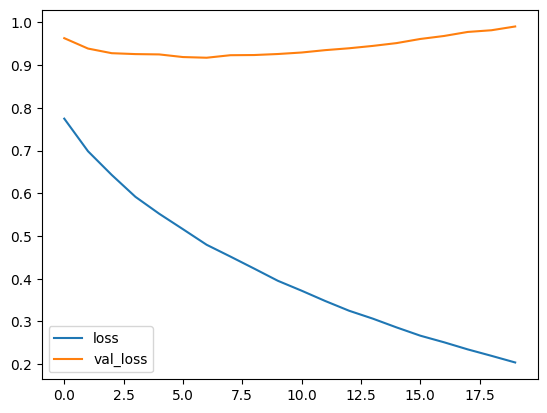

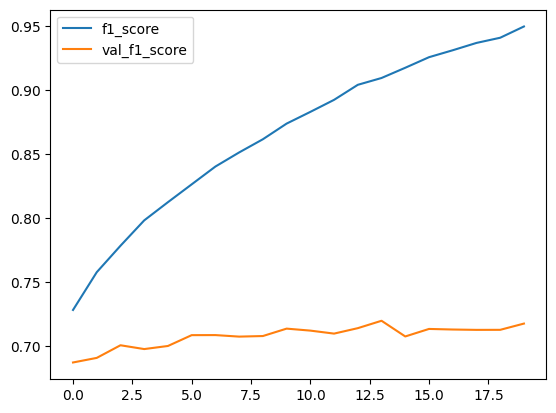

In [22]:
hist = pd.DataFrame(model_1_history_fine.history)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))

hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot() 
plt.show()

## Model 2: Efficient Net, L2 Reg for Output Layers 

In [23]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

class DynamicRegularization(Callback):
    def __init__(self, initial_strength, increase_rate):
        super(DynamicRegularization, self).__init__()
        self.initial_strength = initial_strength
        self.increase_rate = increase_rate

    def on_epoch_begin(self, epoch, logs=None):
        regularization_strength = self.initial_strength + (epoch * self.increase_rate)
        self.model.layers[0].kernel_regularizer = regularizers.l2(regularization_strength)
        print("Regularization strength updated for epoch {}: {}".format(epoch, regularization_strength))


In [24]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

def get_regularization_strength(epoch):
    initial_strength = 0.01
    increase_rate = 0.1

    return initial_strength + (epoch * increase_rate)


inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_2 = tf.keras.Model(inputs, outputs)
checkpoint_path = './checkpoints/model_2/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

dynamic_reg_callback = DynamicRegularization(initial_strength=0.01, increase_rate=0.1)

model_2_history = model_2.fit(train_data, 
                            epochs=10, 
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback, dynamic_reg_callback]) 

Regularization strength updated for epoch 0: 0.01
Epoch 1/10
158/536 [=======>......................] - ETA: 9:18 - loss: 1.8014 - recall: 0.1315 - precision: 0.8230